# Loan Approval Prediction

This notebook builds a model to predict whether a loan will be approved or not.  
We will:
- Handle missing values and encode categorical data  
- Train Logistic Regression and Decision Tree models  
- Handle imbalance using random oversampling  
- Evaluate with Precision, Recall, and F1-score  


## Import Required Libraries  
We import Python libraries for data analysis, preprocessing, visualization, and building ML models.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


## Load Dataset  
Load the loan dataset and display the first few rows to understand its structure.


In [5]:
# Change path if needed (Kaggle usually stores uploaded dataset in ../input/)
df = pd.read_csv("/kaggle/input/loan-approval-prediction/loan_data.csv")
df.head()


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


## 3. Handle Missing Values
We fill missing categorical values with mode and numerical values with median.


In [7]:
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())


## 4. Encode Categorical Variables
We use Label Encoding for categorical columns.


In [9]:
label_enc = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = label_enc.fit_transform(df[col])


## 5. Train-Test Split
We separate features and target, then split into training and testing sets.


In [11]:
# Check actual column names
print("Columns in dataset:", df.columns.tolist())

# Adjust target column name if different
# Common target names: "Loan_Status", "loan_status", "Status", "Approved"
target_column = "Loan_Status"  # <-- Change this if needed
if target_column not in df.columns:
    # Try auto-detect if exact name not found
    for col in df.columns:
        if "status" in col.lower():
            target_column = col
            break

print("Using target column:", target_column)

# Split features and target
X = df.drop(target_column, axis=1)
y = df[target_column]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Columns in dataset: ['person_age', 'person_gender', 'person_education', 'person_income', 'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file', 'loan_status']
Using target column: loan_status


## 6. Handle Imbalanced Data (Random Oversampling)
We oversample the minority class to balance the dataset.


In [14]:
# Combine training features and labels
train_data = pd.concat([X_train, y_train], axis=1)

# Identify target column automatically
target_column = y.name

# Separate majority and minority classes
majority = train_data[train_data[target_column] == train_data[target_column].value_counts().idxmax()]
minority = train_data[train_data[target_column] == train_data[target_column].value_counts().idxmin()]

# Oversample minority class
minority_oversampled = minority.sample(len(majority), replace=True, random_state=42)

# Combine back
balanced_train = pd.concat([majority, minority_oversampled])

# Shuffle
balanced_train = balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Split again
X_train_res = balanced_train.drop(columns=[target_column])
y_train_res = balanced_train[target_column]

print("Before Oversampling:\n", y_train.value_counts())
print("After Oversampling:\n", y_train_res.value_counts())


Before Oversampling:
 loan_status
0    28000
1     8000
Name: count, dtype: int64
After Oversampling:
 loan_status
1    28000
0    28000
Name: count, dtype: int64


## 7. Train and Evaluate Models
We train Logistic Regression, Decision Tree, and Random Forest models.  
Each model is evaluated on test data.


In [17]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    print(f"=== {name} ===")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n" + "-"*50 + "\n")


=== Logistic Regression ===
Accuracy: 0.8248888888888889
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.80      0.88      7000
           1       0.56      0.93      0.70      2000

    accuracy                           0.82      9000
   macro avg       0.77      0.86      0.79      9000
weighted avg       0.88      0.82      0.84      9000

Confusion Matrix:
 [[5573 1427]
 [ 149 1851]]

--------------------------------------------------

=== Decision Tree ===
Accuracy: 0.898
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      7000
           1       0.77      0.77      0.77      2000

    accuracy                           0.90      9000
   macro avg       0.85      0.85      0.85      9000
weighted avg       0.90      0.90      0.90      9000

Confusion Matrix:
 [[6542  458]
 [ 460 1540]]

--------------------------------------------------

=== R

## 8. Model Comparison
We plot the accuracy of all models for quick comparison.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


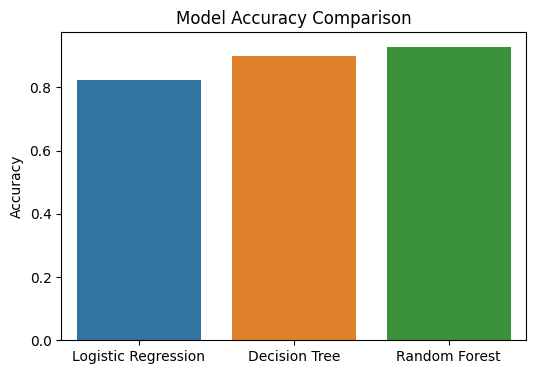

In [18]:
plt.figure(figsize=(6,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()
